# 05_event_database.ipynb

### Create a file format of extreme event attributes


In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.measure import regionprops 
# from dask_image.ndmeasure import label as label_dask
from skimage.measure import label as label_np
from datetime import date
import dask
dask.config.set({"array.slicing.split_large_chunks": False})

#### Import Ocetrac labels and SST data


In [2]:
file_path_list = ('/burg/abernathey/users/hillary/oisst_v21/ocetrac_notrend.nc',
                  '/burg/abernathey/users/hillary/oisst_v21/positive_extremes_OISSTv21.nc')

ds = xr.open_mfdataset(file_path_list)
ssta = ds.mhw_ssta_notrend
labels = ds.ocetrac_labels

print(f"There are {labels.attrs['final objects tracked']} total events tracked.")

ds

There are 770 total events tracked.


<xarray.Dataset>
Dimensions:                     (time: 478, lat: 720, lon: 1440, month: 12)
Coordinates:
  * month                       (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * time                        (time) datetime64[ns] 1981-09-01 ... 2021-06-01
  * lat                         (lat) float32 -89.88 -89.62 ... 89.62 89.88
  * lon                         (lon) float32 0.125 0.375 0.625 ... 359.6 359.9
Data variables:
    ssta_stn_notrend            (time, lat, lon) float64 dask.array<chunksize=(478, 720, 1440), meta=np.ndarray>
    prct_notrend                (month, lat, lon) float64 dask.array<chunksize=(12, 720, 1440), meta=np.ndarray>
    mhw_ssta_notrend            (time, lat, lon) float64 dask.array<chunksize=(478, 720, 1440), meta=np.ndarray>
    mhw_ssta_notrend_noNino3    (time, lat, lon) float64 dask.array<chunksize=(478, 720, 1440), meta=np.ndarray>
    mhw_ssta_notrend_noNino3_4  (time, lat, lon) float64 dask.array<chunksize=(478, 720, 1440), meta=np.ndarray>
    mhw_ssta_notrend_noNino4    (time, lat, lon) float64 dask.array<chunksize=(478, 720, 1440), meta=np.ndarray>
    ocetrac_labels              (time, lat, lon) float64 dask.array<chunksize=(478, 720, 1440), meta=np.ndarray>
Attributes:
    description:  standardized SST anomalies above positive extreme threshold
    threshold:    0.9
    data:         preprocessed monthly averaged OISST v2.1

In [3]:
%%time
labels.load();

CPU times: user 0 ns, sys: 2.51 s, total: 2.51 s
Wall time: 3.31 s


<xarray.DataArray 'ocetrac_labels' (time: 478, lat: 720, lon: 1440)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * time     (time) datetime64[ns] 1981-09-01 1981-10-01 ... 2021-06-01
  * lat      (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 0.125 0.375 0.625 0.875 ... 359.1 359.4 359.6 359.9
Attributes:
    inital objects identified:  13856
    final objects tracked:      770
    radius:                     8
    size quantile threshold:    0.75
    min area:                   2527.0
    percent area reject:        0.19793256167051568
    percent area accept:        0.8020674383294844

#### Event Database
        
- **id** : Unique label given to the MHW [int]
- **date** : Dates corresponding to the event [datetime format]
- **coords** : Latitude and longitude of all points contained in the event [(lat,lon)]
- **centroid** : Center of each object contained in the event [(lat,lon)]
- **duration** : Duration of event [months]
- **intensity_max** : Maximum intensity at each time interval [degC]
- **intensity_mean** : Mean intensity at each time interval [degC]
- **intensity_min** : Minimum intensity at each time interval [degC]
- **intensity_cumulative** : Cumulated intensity over the entire event [degC months]
- **area** : Area of the event at each time interval [km2]

TO ADD?
- number of centroids
- maximum distance between centroids
- date peak [datetime format]
- rate onset [degC / month]
- rate decline [degC / month]

In [4]:
def _get_labels(binary_images):
    '''function used to label binary images at each time step using skimage.measure.label'''
    blobs_labels = label_np(binary_images, background=0)
    return blobs_labels
    
def _get_centroids(sub_labels):
    '''This function uses skimage.measure.regionprops to find the centroids of objects assigned 
    to each unique label'''
    props = regionprops(sub_labels.astype('int'))
    centroids = [(float(sub_labels.lat[round(p.centroid[0])].values), 
                  float(sub_labels.lon[round(p.centroid[1])].values)) for p in props]
    return centroids

def _get_intensity_area(event, ssta, mhw):
    '''Calculates event intensities and area at each time interval using anomaly data and coordinates 
    cooresponding to the event.'''
    
    event_ssta = ssta.where(event>0, drop=True)        
    mhw['intensity_mean'].append(event_ssta.mean(('lat','lon')).values)
    mhw['intensity_max'].append(event_ssta.max(('lat','lon')).values) 
    mhw['intensity_min'].append(event_ssta.min(('lat','lon')).values)
    mhw['intensity_cumulative'].append(np.nansum(event_ssta))
    coords = event.stack(z=('lat','lon'))
    coord_pairs = [(coords.isel(time=t[0]).dropna(dim='z', how='any').z.lat.values, 
                      coords.isel(time=t[0]).dropna(dim='z', how='any').z.lon.values) for t in enumerate(event.time)]

    mhw['coords'].append(coord_pairs)

    # Calculate weighted cell area assuming 0.25º resolution data and 111 km per degree of latitude
    y, x = zip(*coord_pairs)
    dlon = [np.cos(y[c]*np.pi/180)*(111*.25) for c in np.arange(0, len(coord_pairs))]
    dlat = (111*.25) * np.ones(len(dlon))
    cell_area = [np.sum(dlon[c]*dlat[c]) for c in np.arange(0, len(coord_pairs))]
    mhw['area'].append(cell_area)

    return mhw
    
def create_dataset(event, ssta):
    '''
    Creates a Pandas DataFrame of event attributes.
    
    Parameters
    ----------
      event : xarray.DataArray   
              Image set containing only objects corresponding to the event of interest. 
              Dimensions should be ('time', 'lat', 'lon')
              
      ssta  : xarray.DataArray
              Temperature vector [1D numpy array of length T]
    
    Returns
    -------
    
    mhw : pandas.DataFrame
          Marine heat wave event attributes. The keys listed below are 
          are contained within the dataset.
 
        'id'                     Unique label given to the MHW [int]
        'date'                   Dates corresponding to the event [datetime format]
        'coords'                 Latitude and longitude of all points contained in the event [tuple(lat,lon)]
        'centroid'               Center of each object contained in the event [tuple(lat,lon)]
        'duration'               Duration of event [months]
        'intensity_max'          Maximum intensity at each time interval [degC]
        'intensity_mean'         Mean intensity at each time interval [degC]
        'intensity_min'          Minimum intensity at each time interval [degC]
        'intensity_cumulative'   Cumulated intensity over the entire event [degC months]
        'area'                   Area of the event at each time interval [km2]
        
    '''
    
    # Initialize dictionary 
    mhw = {}
    mhw['id'] = [] # event label
    mhw['date'] = [] # datetime format
    mhw['coords'] = [] # (lat, lon)
    mhw['centroid'] = []  # (lat, lon)
    mhw['duration'] = [] # [months]
    mhw['intensity_max'] = [] # [deg C]
    mhw['intensity_mean'] = [] # [deg C]
    mhw['intensity_min'] = [] # [deg C]
    mhw['intensity_cumulative'] = [] # [deg C]
    mhw['area'] = [] # [km2]

    # TO ADD:
    # mhw['rate_onset'] = [] # [deg C / month]
    # mhw['rate_decline'] = [] # [deg C / month]

    mhw['id'].append(int(np.nanmedian(event.values)))
    mhw['date'].append(event.time.values.astype('datetime64[M]'))
    mhw['duration'].append(event.time.shape[0])

    # Turn images into binary
    binary_event = event.where(event>=0, other=0)
    binary_event = binary_event.where(binary_event==0, other=1)
      
    sub_labels = xr.apply_ufunc(_get_labels, binary_event,
                                input_core_dims=[['lat', 'lon']],
                                output_core_dims=[['lat', 'lon']],
                                output_dtypes=[binary_event.dtype],
                                vectorize=True,
                                dask='parallelized')
    
    # Turn background to NaNs
    sub_labels = xr.DataArray(sub_labels, dims=binary_event.dims, coords=binary_event.coords)
    sub_labels = sub_labels.where(sub_labels>0, drop=False, other=np.nan) 

    # The labels are repeated each time step, therefore we relabel them to be consecutive
    for p in range(1, sub_labels.shape[0]):
        sub_labels[p,:,:] = sub_labels[p,:,:].values + sub_labels[p-1,:,:].max().values

    centroid = []
    for s in np.arange(0, sub_labels.shape[0]):
        centroid.append(_get_centroids(sub_labels.isel(time=s)))
    mhw['centroid'].append(centroid)
    
    mhw = _get_intensity_area(event, ssta, mhw)
    
    mhw = pd.DataFrame(dict([(name, pd.Series(data)) for name,data in mhw.items()]))

    return mhw


In [ ]:
# Loop through labels to fill dataset
for i in np.arange(1,5): #num_events+1):
    print(i)
    event = labels.where(labels==i, drop=True)
    mhw = create_dataset(event, ssta)
    
print(f'The keys in this dataset are {list(mhw)}.')

## Let's walk through an example for a single event.

In [5]:
# Event label 
i = 651

In [6]:
event = labels.where(labels==i, drop=True)
print(f'The event is labeled {i}')
print(f'This event lasted {event.time.shape[0]} months.')
print('The dates for this event were', event.time[0].values.astype('datetime64[M]'),
      '–', event.time[-1].values.astype('datetime64[M]'))


The event is labeled 651
This event lasted 61 months.
The dates for this event were 2013-10 – 2018-10


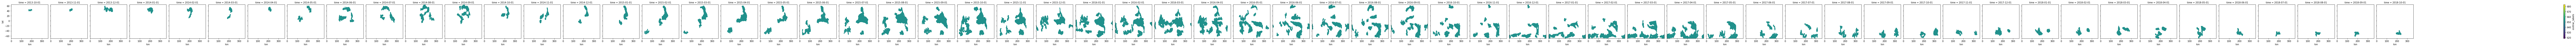

In [7]:
event.plot(col='time', col_wrap=event.shape[0], robust=True);

In [8]:
%%time
mhw = create_dataset(event, ssta)

CPU times: user 5.5 s, sys: 9.33 s, total: 14.8 s
Wall time: 17.2 s


In [9]:
mhw

,id,date,coords,centroid,duration,intensity_max,intensity_mean,intensity_min,intensity_cumulative,area
0,651,"[2013-10, 2013-11, 2013-12, 2014-01, 2014-02, ...","[([38.875, 38.875, 38.875, 38.875, 38.875, 38....","[[(42.875, 185.625)], [(43.875, 198.625)], [(4...",61,"[2.3478753786274638, 2.4350872232164757, 4.934...","[1.120799945576074, 1.558912907988832, 1.73321...","[0.20319337236012736, 0.7157399112553691, 0.46...",2.606768e+06,"[1615863.6858287915, 1901884.0255846302, 83243..."


In [ ]:
import sys
print(f'size of mhw is {sys.getsizeof(mhw)/1e6 *700} mb')

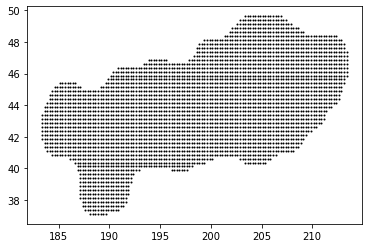

In [10]:
y, x = zip(*mhw['coords'][0])
plt.scatter(x[1], y[1], s=1, c='k')

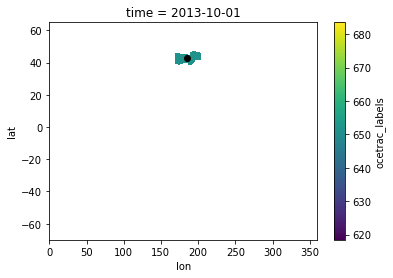

mean intensity (ºC) 1.12
max intensity (ºC) 2.35
min intensity (ºC) 0.2
area (km2) 1615863.69


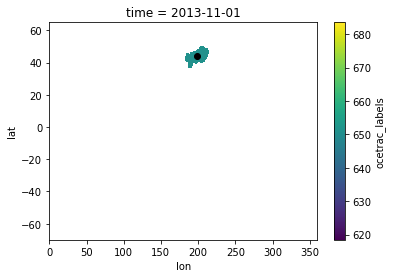

mean intensity (ºC) 1.56
max intensity (ºC) 2.44
min intensity (ºC) 0.72
area (km2) 1901884.03


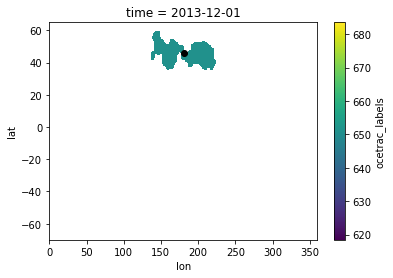

mean intensity (ºC) 1.73
max intensity (ºC) 4.93
min intensity (ºC) 0.47
area (km2) 8324336.2


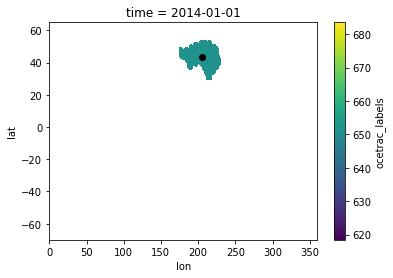

mean intensity (ºC) 1.7
max intensity (ºC) 3.34
min intensity (ºC) 0.49
area (km2) 6959303.15


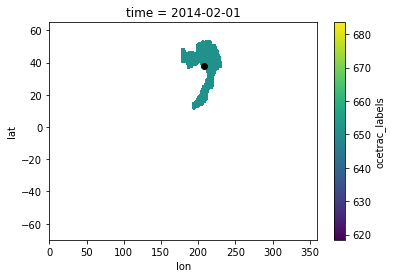

mean intensity (ºC) 1.29
max intensity (ºC) 2.45
min intensity (ºC) 0.42
area (km2) 8659872.15


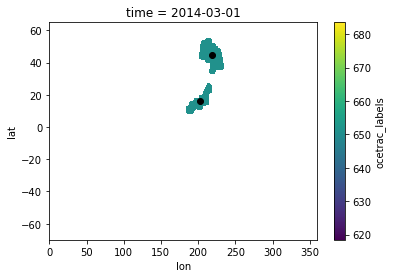

mean intensity (ºC) 1.15
max intensity (ºC) 2.21
min intensity (ºC) 0.43
area (km2) 6607110.32


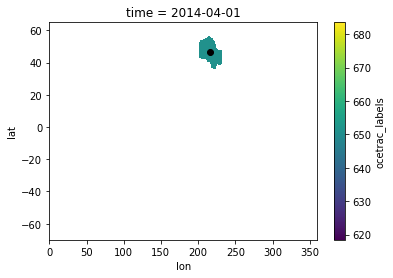

mean intensity (ºC) 1.32
max intensity (ºC) 2.05
min intensity (ºC) 0.61
area (km2) 3045445.18


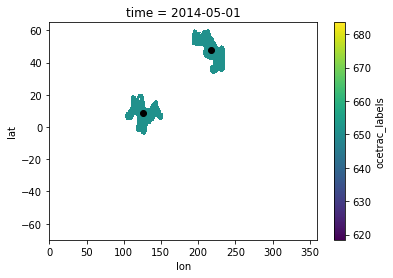

mean intensity (ºC) 1.15
max intensity (ºC) 4.32
min intensity (ºC) 0.25
area (km2) 11243150.59


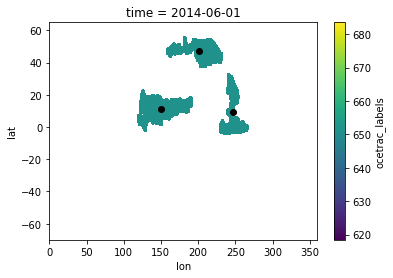

mean intensity (ºC) 1.04
max intensity (ºC) 3.51
min intensity (ºC) 0.23
area (km2) 25278943.08


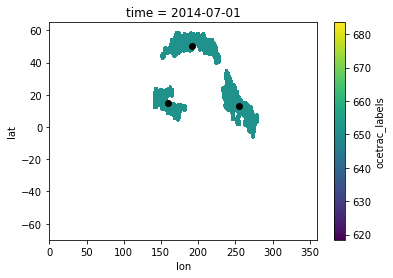

mean intensity (ºC) 1.2
max intensity (ºC) 5.03
min intensity (ºC) 0.11
area (km2) 21395647.52


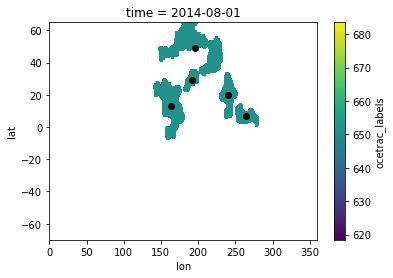

mean intensity (ºC) 1.3
max intensity (ºC) 4.67
min intensity (ºC) 0.23
area (km2) 27373837.77


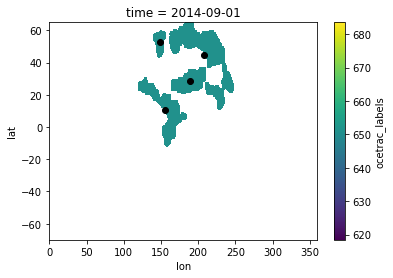

mean intensity (ºC) 1.27
max intensity (ºC) 4.22
min intensity (ºC) 0.35
area (km2) 27492310.86


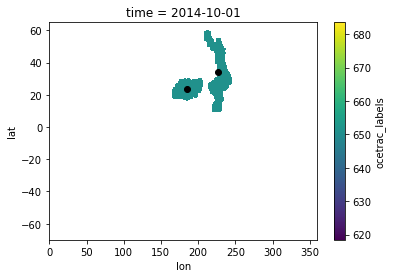

mean intensity (ºC) 1.16
max intensity (ºC) 3.42
min intensity (ºC) 0.3
area (km2) 12032565.19


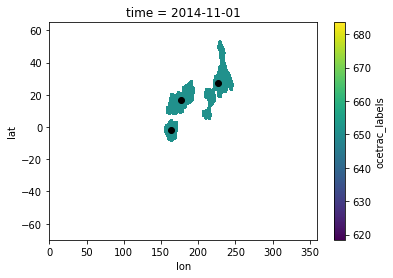

mean intensity (ºC) 0.93
max intensity (ºC) 3.39
min intensity (ºC) 0.25
area (km2) 14063944.61


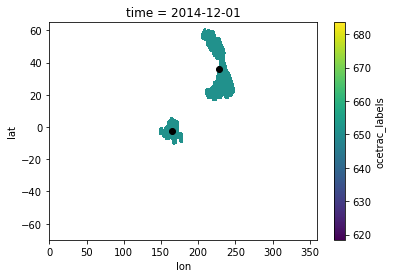

mean intensity (ºC) 1.3
max intensity (ºC) 3.52
min intensity (ºC) 0.22
area (km2) 11655952.68


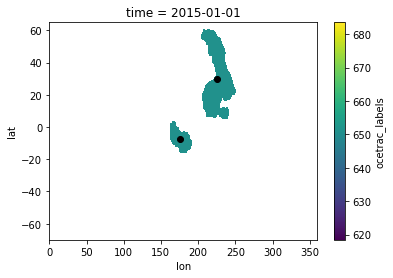

mean intensity (ºC) 1.2
max intensity (ºC) 2.71
min intensity (ºC) 0.33
area (km2) 17265935.4


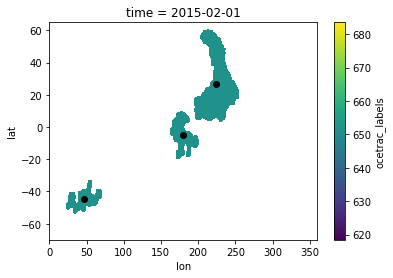

mean intensity (ºC) 1.33
max intensity (ºC) 3.32
min intensity (ºC) 0.37
area (km2) 28156754.62


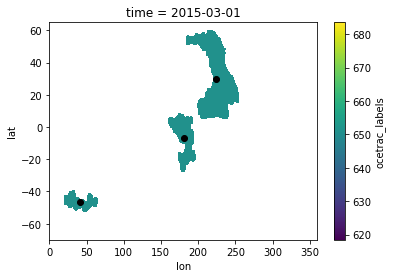

mean intensity (ºC) 1.3
max intensity (ºC) 3.76
min intensity (ºC) 0.31
area (km2) 28044655.79


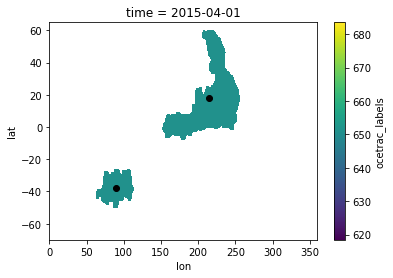

mean intensity (ºC) 1.16
max intensity (ºC) 2.95
min intensity (ºC) 0.27
area (km2) 37777012.04


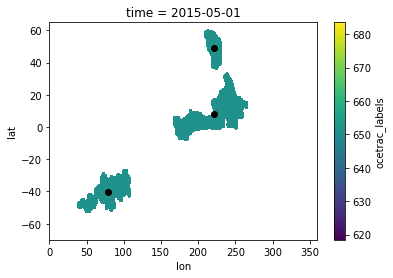

mean intensity (ºC) 1.23
max intensity (ºC) 4.55
min intensity (ºC) 0.33
area (km2) 30302698.49


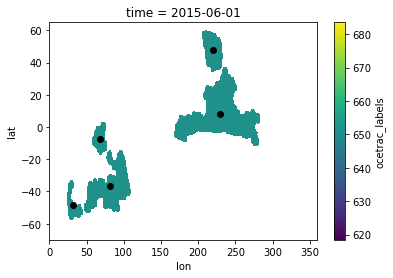

mean intensity (ºC) 1.23
max intensity (ºC) 4.27
min intensity (ºC) 0.22
area (km2) 47688989.7


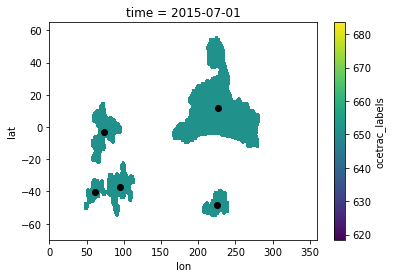

mean intensity (ºC) 1.26
max intensity (ºC) 4.9
min intensity (ºC) 0.07
area (km2) 60243516.07


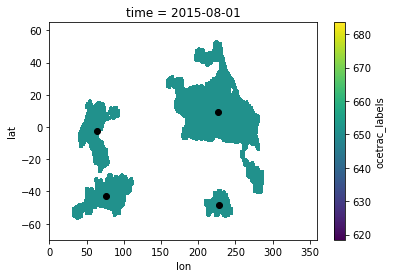

mean intensity (ºC) 1.23
max intensity (ºC) 3.67
min intensity (ºC) 0.24
area (km2) 79949286.16


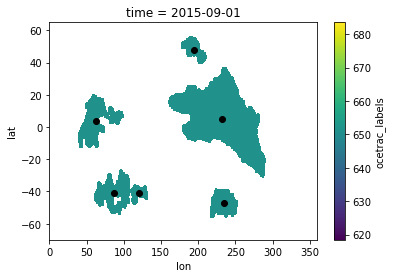

mean intensity (ºC) 1.31
max intensity (ºC) 4.03
min intensity (ºC) 0.11
area (km2) 73406576.03


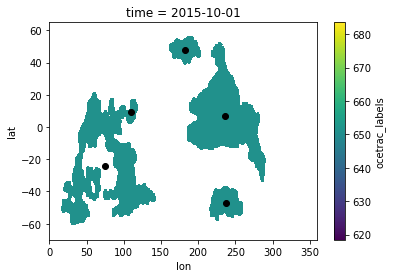

mean intensity (ºC) 1.27
max intensity (ºC) 7.16
min intensity (ºC) 0.08
area (km2) 95300832.73


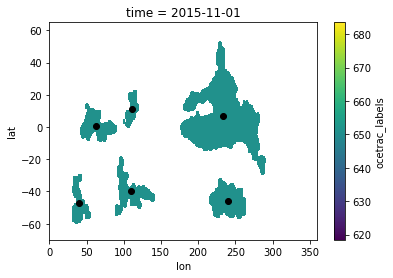

mean intensity (ºC) 1.42
max intensity (ºC) 4.44
min intensity (ºC) 0.17
area (km2) 67286047.47


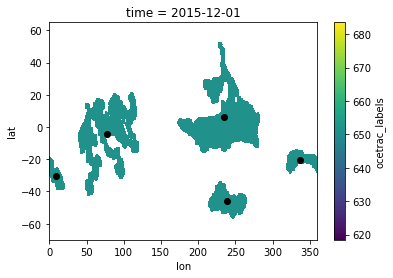

mean intensity (ºC) 1.37
max intensity (ºC) 4.29
min intensity (ºC) 0.14
area (km2) 70881320.42


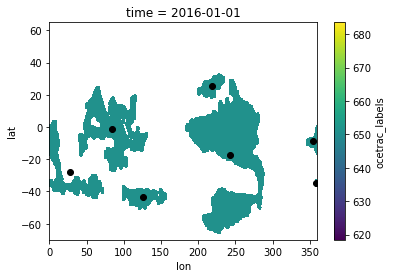

mean intensity (ºC) 1.37
max intensity (ºC) 4.72
min intensity (ºC) 0.24
area (km2) 91632845.04


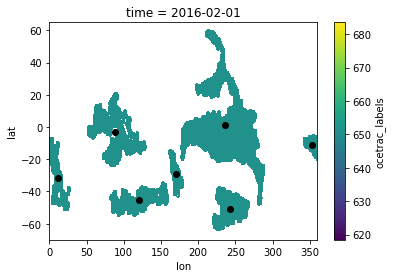

mean intensity (ºC) 1.18
max intensity (ºC) 3.5
min intensity (ºC) 0.13
area (km2) 87980949.28


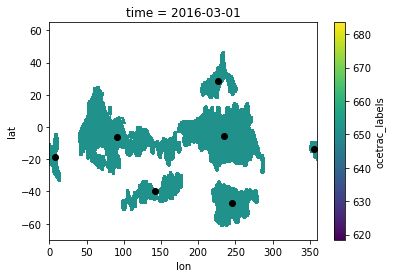

mean intensity (ºC) 1.09
max intensity (ºC) 3.73
min intensity (ºC) 0.2
area (km2) 95546731.43


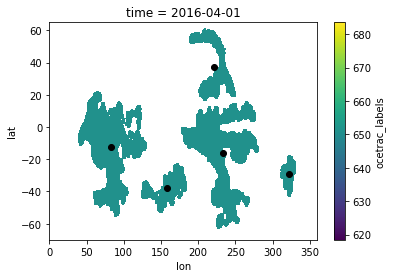

mean intensity (ºC) 1.06
max intensity (ºC) 3.98
min intensity (ºC) 0.18
area (km2) 92641920.53


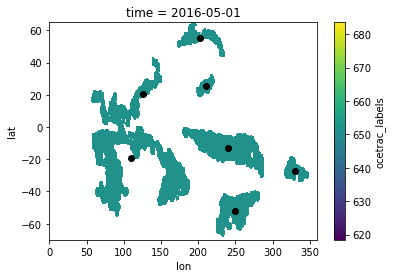

mean intensity (ºC) 1.01
max intensity (ºC) 4.91
min intensity (ºC) 0.09
area (km2) 74207321.16


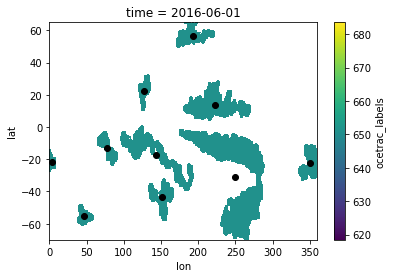

mean intensity (ºC) 1.0
max intensity (ºC) 4.99
min intensity (ºC) 0.13
area (km2) 67767176.04


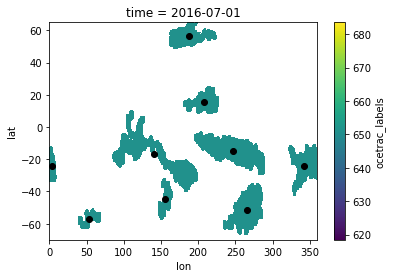

mean intensity (ºC) 1.05
max intensity (ºC) 4.9
min intensity (ºC) 0.07
area (km2) 60927254.81


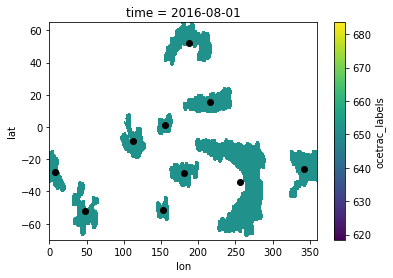

mean intensity (ºC) 1.02
max intensity (ºC) 4.0
min intensity (ºC) -0.07
area (km2) 64744816.49


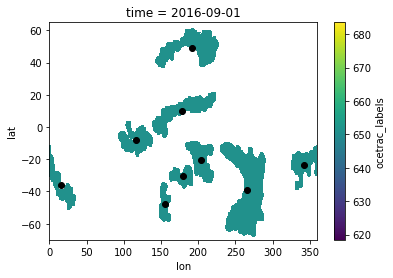

mean intensity (ºC) 1.07
max intensity (ºC) 4.54
min intensity (ºC) 0.09
area (km2) 61274337.38


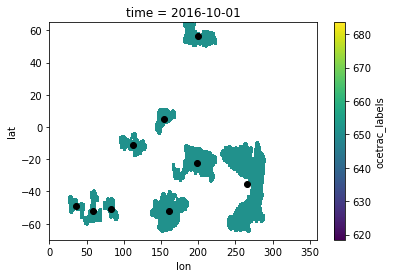

mean intensity (ºC) 0.95
max intensity (ºC) 3.58
min intensity (ºC) 0.2
area (km2) 45464925.03


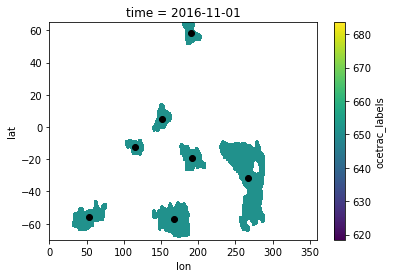

mean intensity (ºC) 0.88
max intensity (ºC) 3.48
min intensity (ºC) 0.07
area (km2) 35566436.33


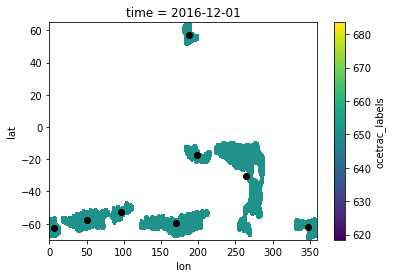

mean intensity (ºC) 0.89
max intensity (ºC) 2.86
min intensity (ºC) -0.03
area (km2) 34160813.68


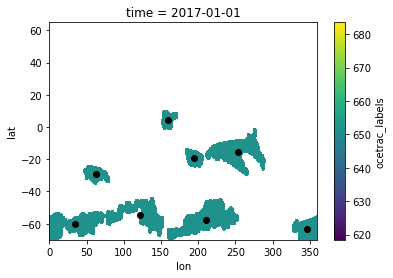

mean intensity (ºC) 1.19
max intensity (ºC) 2.97
min intensity (ºC) 0.08
area (km2) 38704740.7


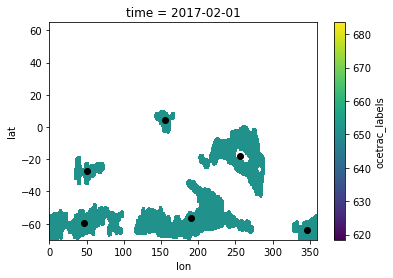

mean intensity (ºC) 1.09
max intensity (ºC) 4.01
min intensity (ºC) 0.12
area (km2) 51347463.48


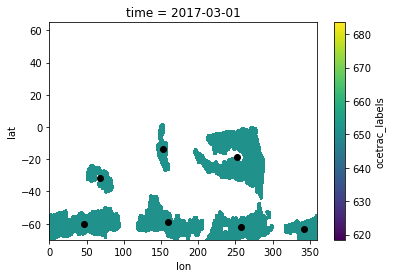

mean intensity (ºC) 0.95
max intensity (ºC) 5.77
min intensity (ºC) -0.1
area (km2) 56222478.6


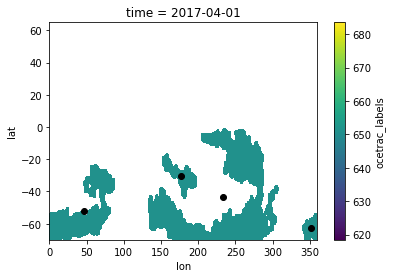

mean intensity (ºC) 0.85
max intensity (ºC) 5.31
min intensity (ºC) -0.04
area (km2) 57302516.2


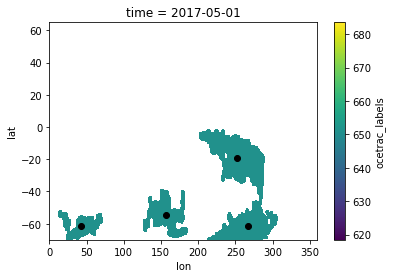

mean intensity (ºC) 0.82
max intensity (ºC) 2.89
min intensity (ºC) 0.02
area (km2) 37051085.85


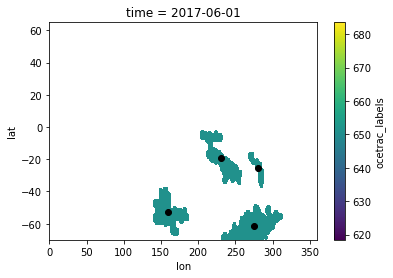

mean intensity (ºC) 0.81
max intensity (ºC) 3.16
min intensity (ºC) 0.09
area (km2) 20389950.08


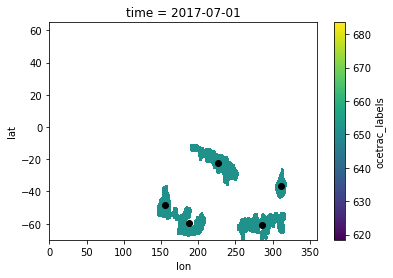

mean intensity (ºC) 0.71
max intensity (ºC) 5.78
min intensity (ºC) 0.01
area (km2) 16882904.42


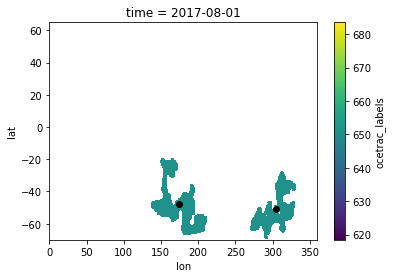

mean intensity (ºC) 0.8
max intensity (ºC) 3.73
min intensity (ºC) -0.04
area (km2) 16873244.77


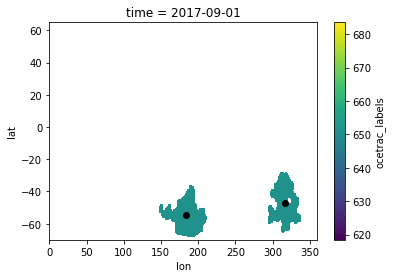

mean intensity (ºC) 0.88
max intensity (ºC) 4.28
min intensity (ºC) 0.02
area (km2) 14398515.81


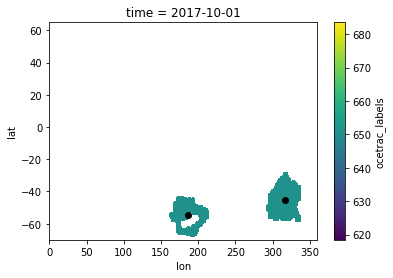

mean intensity (ºC) 0.99
max intensity (ºC) 3.72
min intensity (ºC) 0.16
area (km2) 13540641.61


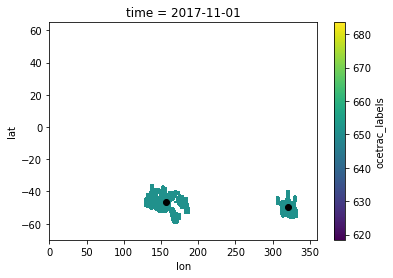

mean intensity (ºC) 1.04
max intensity (ºC) 2.97
min intensity (ºC) 0.21
area (km2) 8183641.92


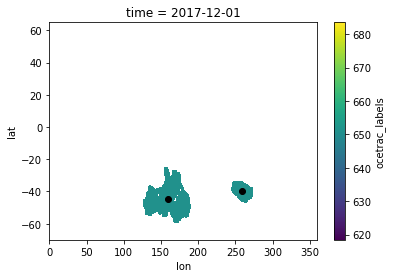

mean intensity (ºC) 1.53
max intensity (ºC) 3.49
min intensity (ºC) 0.35
area (km2) 12880741.36


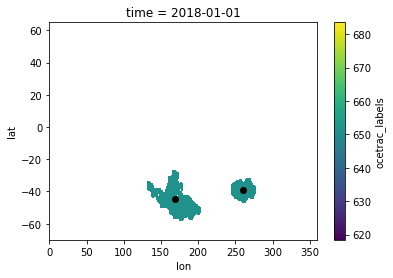

mean intensity (ºC) 1.53
max intensity (ºC) 3.42
min intensity (ºC) 0.47
area (km2) 11272848.61


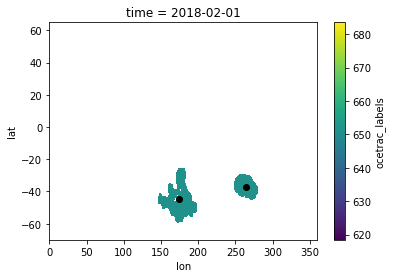

mean intensity (ºC) 1.31
max intensity (ºC) 2.63
min intensity (ºC) 0.46
area (km2) 10071843.26


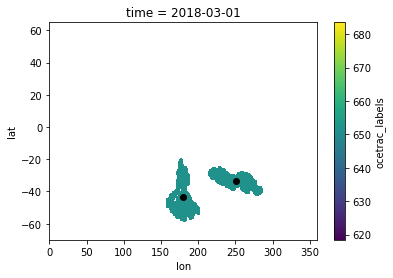

mean intensity (ºC) 1.18
max intensity (ºC) 2.81
min intensity (ºC) 0.34
area (km2) 13611203.17


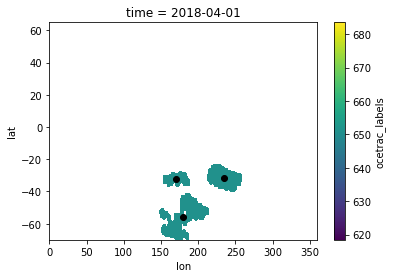

mean intensity (ºC) 1.12
max intensity (ºC) 2.4
min intensity (ºC) -0.05
area (km2) 13381516.42


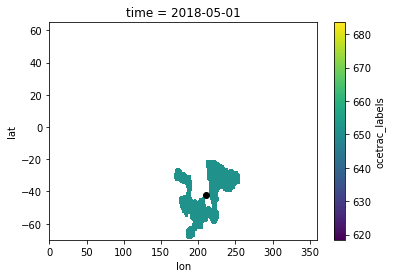

mean intensity (ºC) 1.0
max intensity (ºC) 2.71
min intensity (ºC) 0.08
area (km2) 13890836.0


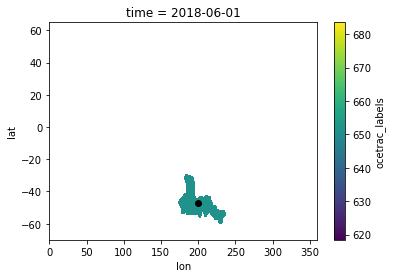

mean intensity (ºC) 0.94
max intensity (ºC) 2.67
min intensity (ºC) 0.33
area (km2) 5993756.73


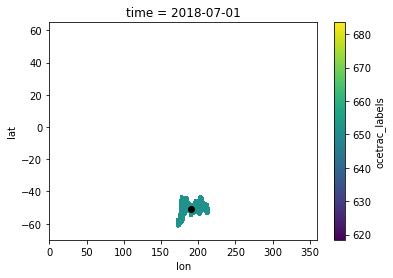

mean intensity (ºC) 0.81
max intensity (ºC) 2.41
min intensity (ºC) 0.22
area (km2) 3288754.11


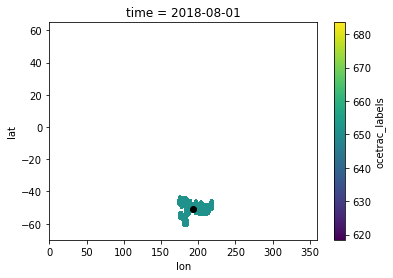

mean intensity (ºC) 0.83
max intensity (ºC) 2.26
min intensity (ºC) 0.33
area (km2) 3547216.23


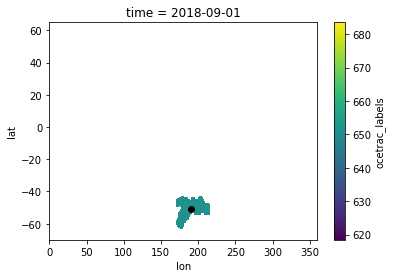

mean intensity (ºC) 0.88
max intensity (ºC) 2.42
min intensity (ºC) 0.37
area (km2) 3631238.83


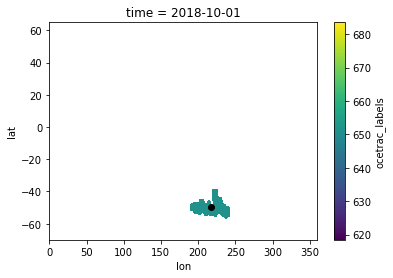

mean intensity (ºC) 0.73
max intensity (ºC) 2.49
min intensity (ºC) 0.29
area (km2) 3568916.54


In [11]:
for c in np.arange(0,mhw['duration'][0]):
    plt.figure()
    y, x = zip(*mhw['centroid'][0][c])
    event[c,:,:].plot()
    plt.scatter(x, y, c='k')
    plt.show()
    print('mean intensity (ºC)', round(mhw['intensity_mean'][0][c],2))
    print('max intensity (ºC)', round(mhw['intensity_max'][0][c],2))
    print('min intensity (ºC)', round(mhw['intensity_min'][0][c],2))
    print('area (km2)', round(mhw['area'][0][c],2))

### To CSV

In [ ]:
path = '/burg/abernathey/users/hillary/oisst_v21/test_dataset.csv'
mhw.to_csv(path, index=False)

In [ ]:
df = pd.read_csv(path)
df